### First check how the dataset looks like

Training samples: 7026


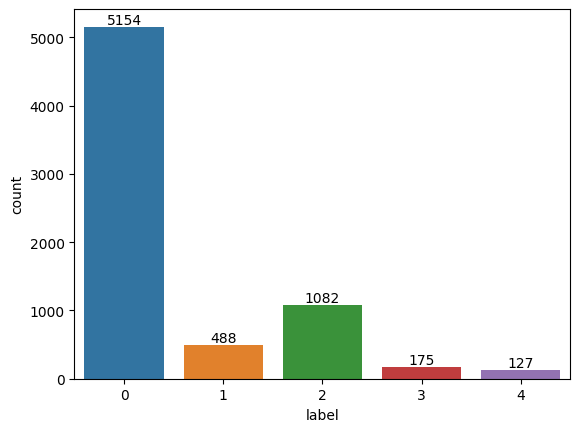

In [1]:
import pandas as pd
from utils import countplot

train_df = pd.read_csv('./test_label.csv', header=None)
train_df.columns = ['label']
print("Training samples:", len(train_df))

countplot(train_df['label'])

### Rebalance dataset if needed

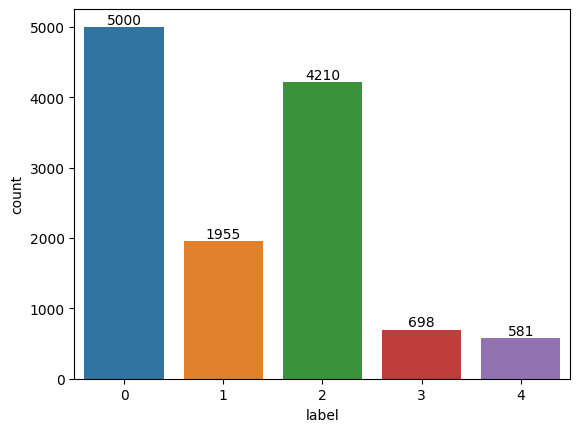

In [2]:
from sklearn.utils import resample

img_df = pd.read_csv('train_img.csv', header=None)
label_df = pd.read_csv('train_label.csv', header=None)

train_df = pd.concat([img_df, label_df], axis=1)
train_df.columns = ['img', 'label']
# print(train_df.head())

zero_df = train_df[train_df['label'] == 0]
resample_df = resample(zero_df, replace=False, n_samples=5000)
# print(resample_df.head(), resample_df.shape)

new_train_df = pd.concat([resample_df, train_df[train_df['label'] != 0]])
# print(new_train_df.shape)

countplot(new_train_df['label'])

### Import modules

In [3]:
from tqdm import tqdm
import argparse
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50
from models.resnet import ResNet18, ResNet50
from dataloader import RetinopathyLoader
from utils import *

torch.manual_seed(0)
device = getDevice()

tranforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
}

Using device: cuda:0, NVIDIA GeForce RTX 3080 Ti


### Train function

In [2]:
def train(model, num_epochs, train_loader, test_loader, optimizer, device, name):
    train_total_loss, train_total_acc, test_total_loss, test_total_acc = [], [], [], []
    best_acc = 0.0
    state = {
        'model': [],
        'acc': 0,
        'epoch': 0,
    }

    print('\n----- start training -----{}'.format(name))
    for epoch in range(num_epochs):
        model.train()
        train_total = 0
        train_loss, train_correct = 0, 0
        for idx, (x, label) in enumerate(tqdm(train_loader)):
            x, label = x.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(x)

            predicted = torch.argmax(output.data, 1)
            train_total += label.size(0)
            train_correct += (predicted == label).sum().item()

            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_total_loss.append(train_loss / len(train_loader))
        train_total_acc.append(100 * train_correct / train_total)

        test_total = 0
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            model.eval()
            for idx, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                outputs = model(data)

                predicted = torch.argmax(outputs.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()

                test_loss += loss_fn(outputs, target).item()
        test_total_loss.append(test_loss / len(test_loader))
        test_total_acc.append(100 * test_correct / test_total)

        print('Epoch: {}/{}'.format(epoch+1, num_epochs))
        print('[Train] loss: {:.5f}, acc: {:.2f}%'.format(train_total_loss[-1], train_total_acc[-1]))
        print('[Test]  loss: {:.5f}, acc: {:.2f}%'.format(test_total_loss[-1], test_total_acc[-1]))

        # save checkpoint
        if test_total_acc[-1] > best_acc:
            best_acc = test_total_acc[-1]
            state['model'] = model.state_dict()
            state['acc'] = test_total_acc[-1]
            state['epoch'] = epoch
            print('- New checkpoint -')

    print('\nBest acc: {:.2f}%'.format(state['acc']))
    torch.save(state, './checkpoint/' + name)

    # evaluate on best model
    model.load_state_dict(state['model'])
    y_true, y_pred = evaluate(model, test_loader, device)
    plot_confusion_matrix(y_true, y_pred, 5, 'true', name)

    return train_total_acc, test_total_acc

In [3]:
num_epochs = 10
lr = 0.003
batch_size = 64
loss_fn = torch.nn.CrossEntropyLoss()

trainset = RetinopathyLoader(root='./data/train/', mode="train", transforms=tranforms['train'])
testset = RetinopathyLoader(root='./data/test/', mode="test", transforms=tranforms['test'])

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

> Found 28100 images...
> Found 7026 images...


### Comparison figure (ResNet18)
- with pretraining
- without pretraining

In [4]:
def show_result(num_epoch, result, model_name):
    # print('result[0]', result[0])
    # print('result[1]', result[1])

    x = np.arange(0, num_epoch)
    plt.figure(figsize=(10, 5))
    plt.title('Result Comparison (' + model_name +')')
    plt.plot(x, result[0][0], label='Train(with pretraining)')
    plt.plot(x, result[0][1], label='Test(with pretraining)')

    plt.plot(x, result[1][0], marker='o', label='Train(w/o pretraining)')
    plt.plot(x, result[1][1], marker='o' ,label='Test(w/o pretraining)')
    plt.legend()
    plt.savefig(model_name + '.png')


----- start training -----ResNet18_(with pretraining)


100%|██████████| 440/440 [02:45<00:00,  2.65it/s]


Epoch: 1/10
[Train] loss: 0.71610, acc: 76.38%
[Test]  loss: 0.60067, acc: 80.09%
- New checkpoint -


100%|██████████| 440/440 [02:47<00:00,  2.63it/s]


Epoch: 2/10
[Train] loss: 0.56881, acc: 81.28%
[Test]  loss: 0.55845, acc: 81.64%
- New checkpoint -


100%|██████████| 440/440 [02:47<00:00,  2.63it/s]


Epoch: 3/10
[Train] loss: 0.53101, acc: 82.67%
[Test]  loss: 0.52682, acc: 83.11%
- New checkpoint -


100%|██████████| 440/440 [02:48<00:00,  2.61it/s]


Epoch: 4/10
[Train] loss: 0.49865, acc: 83.49%
[Test]  loss: 0.50698, acc: 83.08%


100%|██████████| 440/440 [02:48<00:00,  2.61it/s]


Epoch: 5/10
[Train] loss: 0.48058, acc: 84.04%
[Test]  loss: 0.50328, acc: 83.15%
- New checkpoint -


100%|██████████| 440/440 [02:47<00:00,  2.63it/s]


Epoch: 6/10
[Train] loss: 0.46321, acc: 84.47%
[Test]  loss: 0.49535, acc: 84.00%
- New checkpoint -


100%|██████████| 440/440 [02:48<00:00,  2.61it/s]


Epoch: 7/10
[Train] loss: 0.44824, acc: 85.25%
[Test]  loss: 0.51867, acc: 83.49%


100%|██████████| 440/440 [02:48<00:00,  2.60it/s]


Epoch: 8/10
[Train] loss: 0.44367, acc: 85.14%
[Test]  loss: 0.51480, acc: 83.77%


100%|██████████| 440/440 [02:49<00:00,  2.60it/s]


Epoch: 9/10
[Train] loss: 0.42467, acc: 86.00%
[Test]  loss: 0.51334, acc: 83.45%


100%|██████████| 440/440 [02:49<00:00,  2.60it/s]


Epoch: 10/10
[Train] loss: 0.41104, acc: 86.15%
[Test]  loss: 0.64011, acc: 82.25%

Best acc: 84.00%

----- start training -----ResNet18_(without pretraining)


100%|██████████| 440/440 [02:50<00:00,  2.58it/s]


Epoch: 1/10
[Train] loss: 0.87986, acc: 73.22%
[Test]  loss: 0.87171, acc: 73.36%
- New checkpoint -


100%|██████████| 440/440 [02:50<00:00,  2.58it/s]


Epoch: 2/10
[Train] loss: 0.86133, acc: 73.51%
[Test]  loss: 0.84696, acc: 73.24%


100%|██████████| 440/440 [02:50<00:00,  2.58it/s]


Epoch: 3/10
[Train] loss: 0.85504, acc: 73.49%
[Test]  loss: 0.84394, acc: 73.36%


100%|██████████| 440/440 [02:50<00:00,  2.57it/s]


Epoch: 4/10
[Train] loss: 0.85170, acc: 73.51%
[Test]  loss: 0.84719, acc: 73.36%


100%|██████████| 440/440 [02:50<00:00,  2.58it/s]


Epoch: 5/10
[Train] loss: 0.85012, acc: 73.50%
[Test]  loss: 0.84122, acc: 73.34%


100%|██████████| 440/440 [02:50<00:00,  2.58it/s]


Epoch: 6/10
[Train] loss: 0.84309, acc: 73.52%
[Test]  loss: 0.84232, acc: 73.36%


100%|██████████| 440/440 [02:50<00:00,  2.58it/s]


Epoch: 7/10
[Train] loss: 0.83938, acc: 73.51%
[Test]  loss: 0.83908, acc: 73.36%


100%|██████████| 440/440 [02:50<00:00,  2.58it/s]


Epoch: 8/10
[Train] loss: 0.83837, acc: 73.49%
[Test]  loss: 0.86385, acc: 73.34%


100%|██████████| 440/440 [02:50<00:00,  2.58it/s]


Epoch: 9/10
[Train] loss: 0.83219, acc: 73.51%
[Test]  loss: 0.82861, acc: 73.31%


100%|██████████| 440/440 [02:50<00:00,  2.58it/s]


Epoch: 10/10
[Train] loss: 0.82643, acc: 73.51%
[Test]  loss: 0.84608, acc: 73.28%

Best acc: 73.36%


<Figure size 640x480 with 0 Axes>

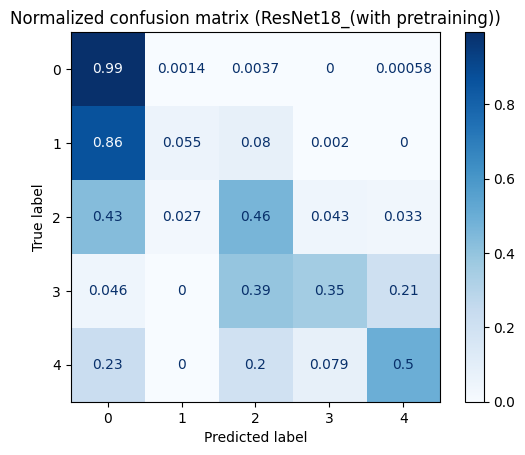

<Figure size 640x480 with 0 Axes>

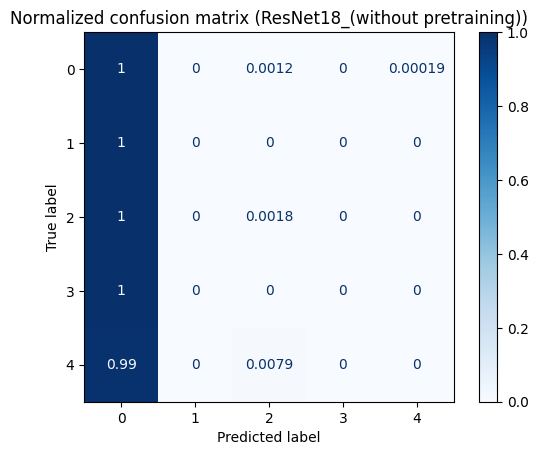

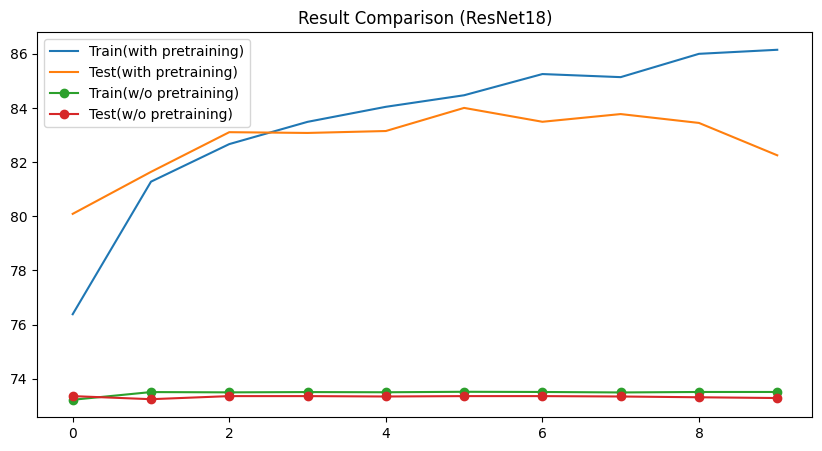

In [7]:
pre_model = resnet18(weights="DEFAULT")
pre_model.fc = nn.Linear(pre_model.fc.in_features, 5)
pre_model = pre_model.to(device)

no_model = ResNet18()
no_model = no_model.to(device)

result = []
models = {
    '(with pretraining)': pre_model,
    '(without pretraining)': no_model
}

for name, model in models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    train_acc, test_acc = train(model, num_epochs, train_loader, test_loader, optimizer, device, 'ResNet18_' + name)
    result.append([train_acc, test_acc])

show_result(num_epochs, result, 'ResNet18')

### Comparison figure (ResNet50)
- with pretraining
- without pretraining


----- start training -----ResNet50(with pretraining)


100%|██████████| 1757/1757 [05:55<00:00,  4.95it/s]


Epoch: 1/10
[Train] loss: 0.66647, acc: 78.24%
[Test]  loss: 0.57753, acc: 80.79%
- New checkpoint -


100%|██████████| 1757/1757 [05:54<00:00,  4.95it/s]


Epoch: 2/10
[Train] loss: 0.54212, acc: 82.06%
[Test]  loss: 0.51277, acc: 83.12%
- New checkpoint -


100%|██████████| 1757/1757 [05:54<00:00,  4.96it/s]


Epoch: 3/10
[Train] loss: 0.50101, acc: 83.25%
[Test]  loss: 0.51931, acc: 82.49%


100%|██████████| 1757/1757 [05:54<00:00,  4.96it/s]


Epoch: 4/10
[Train] loss: 0.48184, acc: 84.09%
[Test]  loss: 0.49862, acc: 83.95%
- New checkpoint -


100%|██████████| 1757/1757 [05:55<00:00,  4.94it/s]


Epoch: 5/10
[Train] loss: 0.46059, acc: 84.67%
[Test]  loss: 0.53453, acc: 83.19%


100%|██████████| 1757/1757 [05:55<00:00,  4.94it/s]


Epoch: 6/10
[Train] loss: 0.44424, acc: 85.13%
[Test]  loss: 0.50618, acc: 83.69%


100%|██████████| 1757/1757 [05:55<00:00,  4.94it/s]


Epoch: 7/10
[Train] loss: 0.43219, acc: 85.49%
[Test]  loss: 0.49148, acc: 84.03%
- New checkpoint -


100%|██████████| 1757/1757 [05:53<00:00,  4.97it/s]


Epoch: 8/10
[Train] loss: 0.41706, acc: 86.17%
[Test]  loss: 0.49794, acc: 84.19%
- New checkpoint -


100%|██████████| 1757/1757 [05:54<00:00,  4.96it/s]


Epoch: 9/10
[Train] loss: 0.40778, acc: 86.24%
[Test]  loss: 0.48669, acc: 84.69%
- New checkpoint -


100%|██████████| 1757/1757 [05:54<00:00,  4.96it/s]


Epoch: 10/10
[Train] loss: 0.39771, acc: 86.64%
[Test]  loss: 0.48120, acc: 83.90%

Best acc: 84.69%

----- start training -----ResNet50(without pretraining)


100%|██████████| 1757/1757 [05:54<00:00,  4.96it/s]


Epoch: 1/10
[Train] loss: 0.91842, acc: 72.91%
[Test]  loss: 0.88691, acc: 73.36%
- New checkpoint -


100%|██████████| 1757/1757 [05:53<00:00,  4.96it/s]


Epoch: 2/10
[Train] loss: 0.87886, acc: 73.48%
[Test]  loss: 0.90091, acc: 73.36%


100%|██████████| 1757/1757 [05:54<00:00,  4.96it/s]


Epoch: 3/10
[Train] loss: 0.87092, acc: 73.49%
[Test]  loss: 0.86827, acc: 73.36%


100%|██████████| 1757/1757 [05:54<00:00,  4.96it/s]


Epoch: 4/10
[Train] loss: 0.87176, acc: 73.45%
[Test]  loss: 0.86227, acc: 73.36%


100%|██████████| 1757/1757 [05:55<00:00,  4.95it/s]


Epoch: 5/10
[Train] loss: 0.86871, acc: 73.47%
[Test]  loss: 0.87141, acc: 73.31%


100%|██████████| 1757/1757 [05:54<00:00,  4.96it/s]


Epoch: 6/10
[Train] loss: 0.86823, acc: 73.49%
[Test]  loss: 0.86541, acc: 73.36%


100%|██████████| 1757/1757 [05:55<00:00,  4.94it/s]


Epoch: 7/10
[Train] loss: 0.86905, acc: 73.47%
[Test]  loss: 0.86901, acc: 73.27%


100%|██████████| 1757/1757 [05:55<00:00,  4.94it/s]


Epoch: 8/10
[Train] loss: 0.86835, acc: 73.51%
[Test]  loss: 0.85794, acc: 73.36%


100%|██████████| 1757/1757 [05:56<00:00,  4.93it/s]


Epoch: 9/10
[Train] loss: 0.86620, acc: 73.51%
[Test]  loss: 2.38900, acc: 73.36%


100%|██████████| 1757/1757 [05:55<00:00,  4.94it/s]


Epoch: 10/10
[Train] loss: 0.86471, acc: 73.51%
[Test]  loss: 0.88172, acc: 73.36%

Best acc: 73.36%


<Figure size 640x480 with 0 Axes>

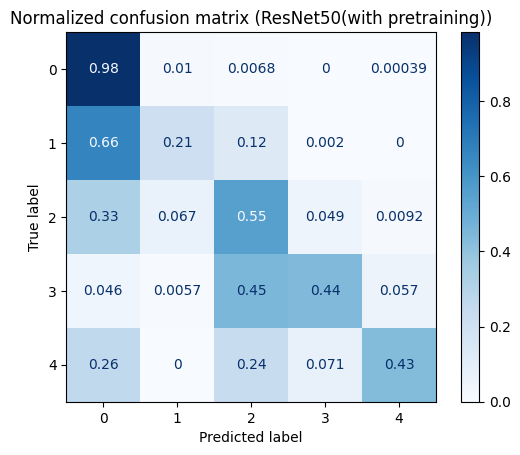

<Figure size 640x480 with 0 Axes>

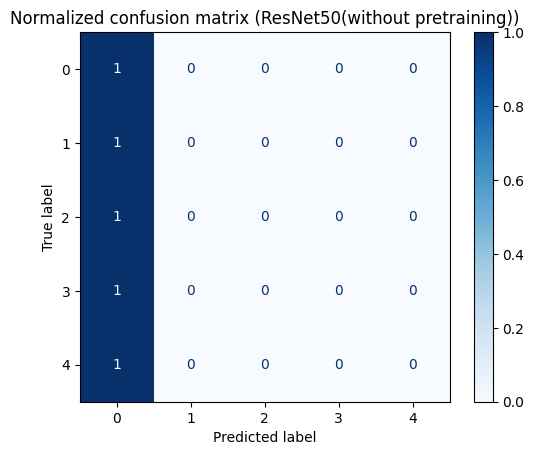

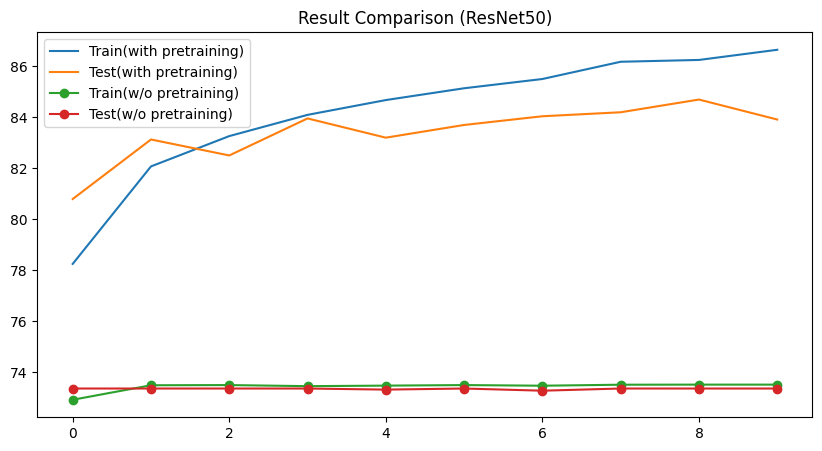

In [5]:
pre_model = resnet50(weights="DEFAULT")
pre_model.fc = nn.Linear(pre_model.fc.in_features, 5)
pre_model = pre_model.to(device)

no_model = ResNet50()
no_model = no_model.to(device)

result = []
models = {
    '(with pretraining)': pre_model,
    '(without pretraining)': no_model
}

batch_size = 16
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

for name, model in models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    train_acc, test_acc = train(model, num_epochs, train_loader, test_loader, optimizer, device, 'ResNet50' + name)
    result.append([train_acc, test_acc])

show_result(num_epochs, result, 'ResNet50')

### Transfer learning (freeze the network parameter except the final layer)
- with resize 224 * 224
- without resize 224 * 224

In [16]:
new_tranforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
}
trainset = RetinopathyLoader(root='./data/train/', mode="train", transforms=new_tranforms['train'])
testset = RetinopathyLoader(root='./data/test/', mode="test", transforms=new_tranforms['test'])

> Found 28100 images...
> Found 7026 images...



----- start training -----TLR_(Resnet18, resize)


  0%|          | 0/440 [00:00<?, ?it/s]/home/michaellee/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 440/440 [00:51<00:00,  8.53it/s]


Epoch: 1/10
[Train] loss: 0.82151, acc: 73.42%
[Test]  loss: 0.78117, acc: 73.93%
- New checkpoint -


100%|██████████| 440/440 [00:51<00:00,  8.56it/s]


Epoch: 2/10
[Train] loss: 0.77879, acc: 74.08%
[Test]  loss: 0.82560, acc: 70.47%


100%|██████████| 440/440 [00:51<00:00,  8.56it/s]


Epoch: 3/10
[Train] loss: 0.77382, acc: 73.99%
[Test]  loss: 0.76371, acc: 74.01%
- New checkpoint -


100%|██████████| 440/440 [00:51<00:00,  8.55it/s]


Epoch: 4/10
[Train] loss: 0.77243, acc: 74.32%
[Test]  loss: 0.76083, acc: 74.10%
- New checkpoint -


100%|██████████| 440/440 [00:51<00:00,  8.56it/s]


Epoch: 5/10
[Train] loss: 0.77382, acc: 74.00%
[Test]  loss: 0.80694, acc: 72.10%


100%|██████████| 440/440 [00:51<00:00,  8.57it/s]


Epoch: 6/10
[Train] loss: 0.76598, acc: 74.25%
[Test]  loss: 0.79422, acc: 74.08%


100%|██████████| 440/440 [00:51<00:00,  8.56it/s]


Epoch: 7/10
[Train] loss: 0.77014, acc: 74.18%
[Test]  loss: 0.77892, acc: 74.17%
- New checkpoint -


100%|██████████| 440/440 [00:51<00:00,  8.57it/s]


Epoch: 8/10
[Train] loss: 0.76891, acc: 74.11%
[Test]  loss: 0.79735, acc: 74.20%
- New checkpoint -


100%|██████████| 440/440 [00:51<00:00,  8.58it/s]


Epoch: 9/10
[Train] loss: 0.76153, acc: 74.32%
[Test]  loss: 0.78952, acc: 74.34%
- New checkpoint -


100%|██████████| 440/440 [00:51<00:00,  8.57it/s]


Epoch: 10/10
[Train] loss: 0.76273, acc: 74.33%
[Test]  loss: 0.79721, acc: 73.85%

Best acc: 74.34%

----- start training -----TLR_(Resnet50, resize)


  0%|          | 0/1757 [00:00<?, ?it/s]/home/michaellee/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1757/1757 [01:09<00:00, 25.40it/s]


Epoch: 1/10
[Train] loss: 0.82069, acc: 73.67%
[Test]  loss: 0.79347, acc: 74.11%
- New checkpoint -


100%|██████████| 1757/1757 [01:09<00:00, 25.46it/s]


Epoch: 2/10
[Train] loss: 0.77522, acc: 74.10%
[Test]  loss: 0.76429, acc: 74.41%
- New checkpoint -


100%|██████████| 1757/1757 [01:09<00:00, 25.43it/s]


Epoch: 3/10
[Train] loss: 0.75883, acc: 74.41%
[Test]  loss: 0.76162, acc: 74.15%


100%|██████████| 1757/1757 [01:09<00:00, 25.44it/s]


Epoch: 4/10
[Train] loss: 0.74726, acc: 74.69%
[Test]  loss: 0.75163, acc: 74.61%
- New checkpoint -


100%|██████████| 1757/1757 [01:09<00:00, 25.39it/s]


Epoch: 5/10
[Train] loss: 0.74356, acc: 74.90%
[Test]  loss: 0.74712, acc: 74.71%
- New checkpoint -


100%|██████████| 1757/1757 [01:09<00:00, 25.36it/s]


Epoch: 6/10
[Train] loss: 0.74069, acc: 74.93%
[Test]  loss: 0.74473, acc: 74.65%


100%|██████████| 1757/1757 [01:09<00:00, 25.36it/s]


Epoch: 7/10
[Train] loss: 0.73569, acc: 75.05%
[Test]  loss: 0.75031, acc: 74.51%


100%|██████████| 1757/1757 [01:09<00:00, 25.41it/s]


Epoch: 8/10
[Train] loss: 0.73380, acc: 75.00%
[Test]  loss: 0.74499, acc: 74.65%


100%|██████████| 1757/1757 [01:09<00:00, 25.31it/s]


Epoch: 9/10
[Train] loss: 0.73170, acc: 75.07%
[Test]  loss: 0.74496, acc: 74.89%
- New checkpoint -


100%|██████████| 1757/1757 [01:09<00:00, 25.41it/s]


Epoch: 10/10
[Train] loss: 0.73434, acc: 75.05%
[Test]  loss: 0.76311, acc: 73.83%

Best acc: 74.89%


<Figure size 640x480 with 0 Axes>

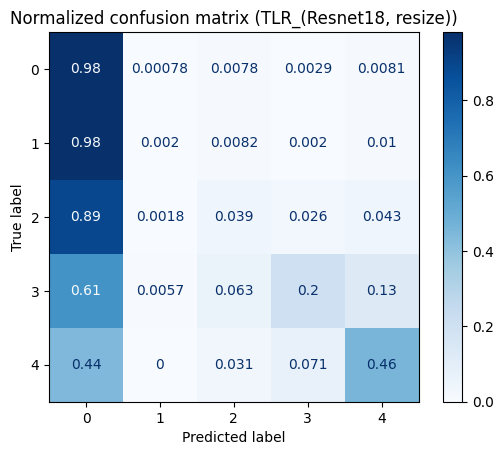

<Figure size 640x480 with 0 Axes>

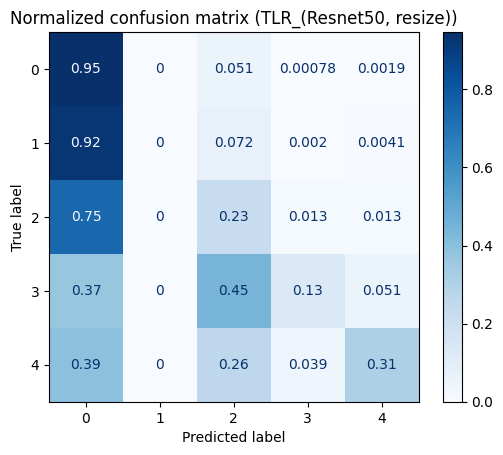

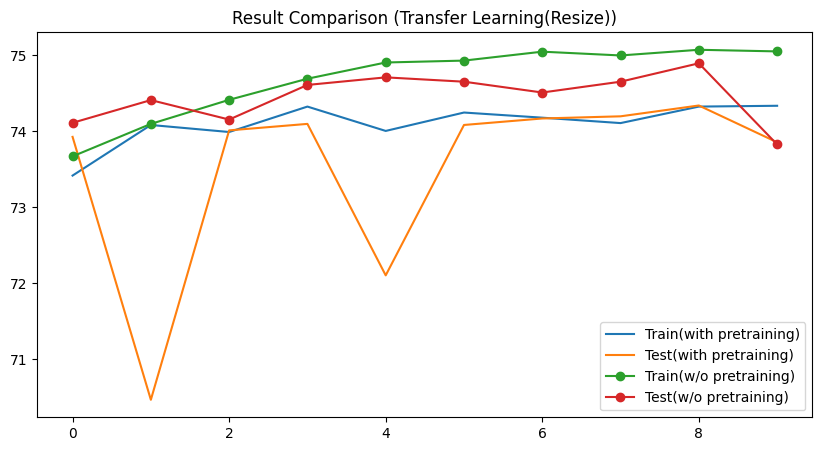

In [17]:
Resnet18 = resnet18(weights="DEFAULT")
for param in Resnet18.parameters():
    param.requires_grad = False
Resnet18.fc = nn.Linear(Resnet18.fc.in_features, 5)
Resnet18 = Resnet18.to(device)

Resnet50 = resnet50(weights="DEFAULT")
for param in Resnet50.parameters():
    param.requires_grad = False
Resnet50.fc = nn.Linear(Resnet50.fc.in_features, 5)
Resnet50 = Resnet50.to(device)

batch_sizes = [64, 16]
result = []
models = {
    '(Resnet18, resize)': Resnet18,
    '(Resnet50, resize)': Resnet50
}

for idx, (name, model) in enumerate(models.items()):
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_sizes[idx], shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_sizes[idx], shuffle=True)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
    train_acc, test_acc = train(model, num_epochs, train_loader, test_loader, optimizer, device, 'TLR_' + name)
    result.append([train_acc, test_acc])

show_result(num_epochs, result, 'Transfer Learning(Resize)')

### Fine tuning (retrain all the network parameters)
- with resize 224 * 224


----- start training -----FT_(Resnet18)


100%|██████████| 440/440 [01:05<00:00,  6.72it/s]


Epoch: 1/10
[Train] loss: 0.75907, acc: 74.97%
[Test]  loss: 0.71708, acc: 75.96%
- New checkpoint -


100%|██████████| 440/440 [01:06<00:00,  6.57it/s]


Epoch: 2/10
[Train] loss: 0.67011, acc: 77.45%
[Test]  loss: 0.72060, acc: 77.77%
- New checkpoint -


100%|██████████| 440/440 [01:06<00:00,  6.59it/s]


Epoch: 3/10
[Train] loss: 0.62765, acc: 79.12%
[Test]  loss: 0.64246, acc: 78.00%
- New checkpoint -


100%|██████████| 440/440 [01:06<00:00,  6.65it/s]


Epoch: 4/10
[Train] loss: 0.59576, acc: 80.21%
[Test]  loss: 0.66546, acc: 78.57%
- New checkpoint -


100%|██████████| 440/440 [01:06<00:00,  6.61it/s]


Epoch: 5/10
[Train] loss: 0.57311, acc: 80.74%
[Test]  loss: 0.65829, acc: 77.17%


100%|██████████| 440/440 [01:06<00:00,  6.60it/s]


Epoch: 6/10
[Train] loss: 0.54260, acc: 81.69%
[Test]  loss: 0.63757, acc: 79.72%
- New checkpoint -


100%|██████████| 440/440 [01:07<00:00,  6.50it/s]


Epoch: 7/10
[Train] loss: 0.51794, acc: 82.50%
[Test]  loss: 0.84722, acc: 78.92%


100%|██████████| 440/440 [01:07<00:00,  6.49it/s]


Epoch: 8/10
[Train] loss: 0.50095, acc: 83.19%
[Test]  loss: 0.63267, acc: 79.49%


100%|██████████| 440/440 [01:07<00:00,  6.53it/s]


Epoch: 9/10
[Train] loss: 0.48102, acc: 83.61%
[Test]  loss: 0.64019, acc: 80.12%
- New checkpoint -


100%|██████████| 440/440 [01:07<00:00,  6.56it/s]


Epoch: 10/10
[Train] loss: 0.45813, acc: 84.22%
[Test]  loss: 0.68299, acc: 76.91%

Best acc: 80.12%

----- start training -----FT_(Resnet50)


  0%|          | 0/1757 [00:00<?, ?it/s]/home/michaellee/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1757/1757 [01:50<00:00, 15.84it/s]


Epoch: 1/10
[Train] loss: 0.73675, acc: 75.79%
[Test]  loss: 0.64601, acc: 78.57%
- New checkpoint -


100%|██████████| 1757/1757 [01:51<00:00, 15.81it/s]


Epoch: 2/10
[Train] loss: 0.63282, acc: 78.96%
[Test]  loss: 0.60550, acc: 80.15%
- New checkpoint -


100%|██████████| 1757/1757 [01:51<00:00, 15.70it/s]


Epoch: 3/10
[Train] loss: 0.58910, acc: 80.56%
[Test]  loss: 0.59492, acc: 80.86%
- New checkpoint -


100%|██████████| 1757/1757 [01:51<00:00, 15.71it/s]


Epoch: 4/10
[Train] loss: 0.56238, acc: 81.44%
[Test]  loss: 0.57747, acc: 81.16%
- New checkpoint -


100%|██████████| 1757/1757 [01:51<00:00, 15.76it/s]


Epoch: 5/10
[Train] loss: 0.53467, acc: 82.24%
[Test]  loss: 0.57610, acc: 81.45%
- New checkpoint -


100%|██████████| 1757/1757 [01:52<00:00, 15.66it/s]


Epoch: 6/10
[Train] loss: 0.51687, acc: 82.76%
[Test]  loss: 0.57945, acc: 81.40%


100%|██████████| 1757/1757 [01:51<00:00, 15.71it/s]


Epoch: 7/10
[Train] loss: 0.50024, acc: 83.20%
[Test]  loss: 0.57356, acc: 81.16%


100%|██████████| 1757/1757 [01:51<00:00, 15.70it/s]


Epoch: 8/10
[Train] loss: 0.48577, acc: 83.76%
[Test]  loss: 0.57263, acc: 81.31%


100%|██████████| 1757/1757 [01:51<00:00, 15.76it/s]


Epoch: 9/10
[Train] loss: 0.47128, acc: 84.07%
[Test]  loss: 0.59367, acc: 80.69%


100%|██████████| 1757/1757 [01:51<00:00, 15.75it/s]


Epoch: 10/10
[Train] loss: 0.45990, acc: 84.44%
[Test]  loss: 0.58334, acc: 81.74%
- New checkpoint -

Best acc: 81.74%


<Figure size 640x480 with 0 Axes>

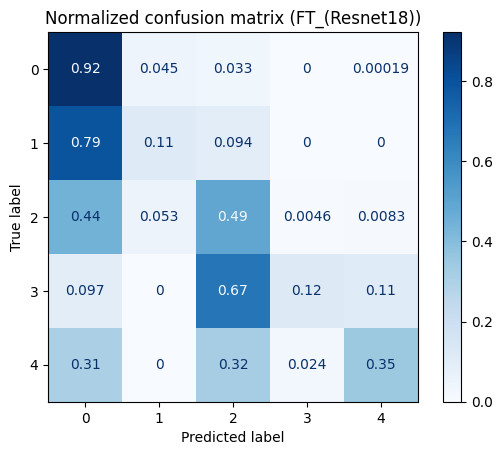

<Figure size 640x480 with 0 Axes>

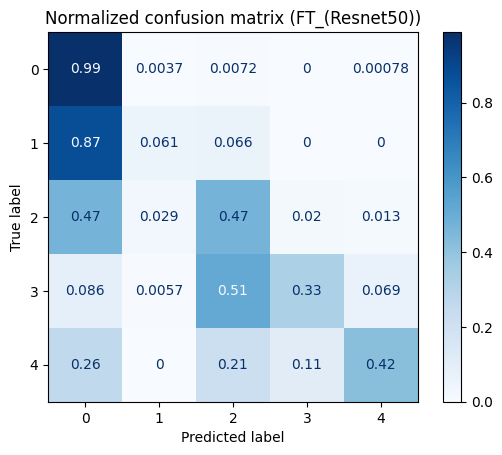

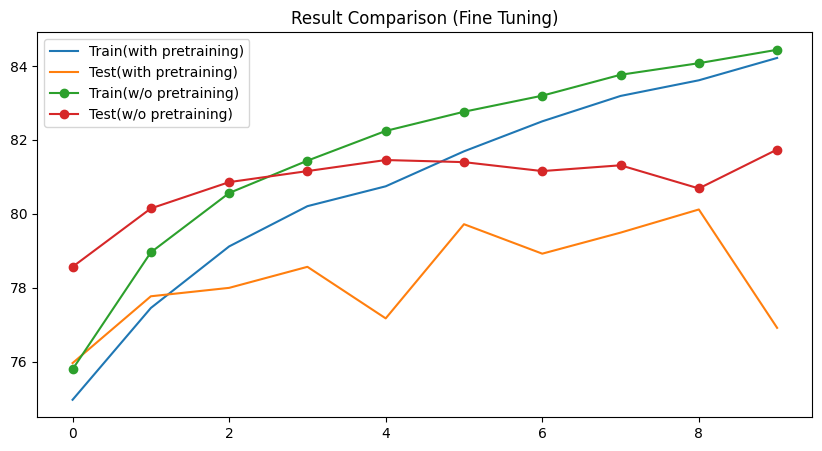

In [15]:
Resnet18 = resnet18(weights="DEFAULT")
Resnet18.fc = nn.Linear(Resnet18.fc.in_features, 5)
Resnet18 = Resnet18.to(device)

Resnet50 = resnet50(weights="DEFAULT")
Resnet50.fc = nn.Linear(Resnet50.fc.in_features, 5)
Resnet50 = Resnet50.to(device)

batch_sizes = [64, 16]
result = []
models = {
    '(Resnet18)': Resnet18,
    '(Resnet50)': Resnet50
}

for idx, (name, model) in enumerate(models.items()):
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_sizes[idx], shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_sizes[idx], shuffle=True)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
    train_acc, test_acc = train(model, num_epochs, train_loader, test_loader, optimizer, device, 'FT_' + name)
    result.append([train_acc, test_acc])

show_result(num_epochs, result, 'Fine Tuning')

### Visualize where the model focused on the image (Explainable AI)

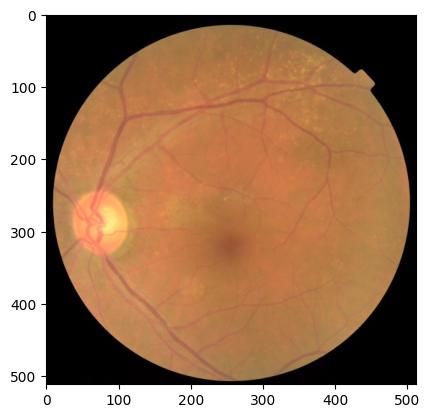

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch import topk
import skimage

class SaveFeatures():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()

    def remove(self):
        self.hook.remove()

def getCAM(feature_conv, weight_fc, class_idx):
    _, c, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape(c, h*w))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img

image = Image.open("./data/test/363_left.jpeg")
plt.imshow(image)

In [5]:
vis_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
display_transform = transforms.Compose([
    transforms.Resize((512, 512)),
])

image_tensor = vis_transform(image)

# load pretrained resnet18
checkpoint = torch.load("./checkpoint/ResNet18_(with pretraining)")
model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 5)
model.load_state_dict(checkpoint['model'])
model = model.cuda()
model.eval()

activated_features = SaveFeatures(model.layer4)
prediction = model(image_tensor.unsqueeze(0).cuda())
probabilities = torch.nn.functional.softmax(prediction).data.squeeze()
activated_features.remove()
print('Prediction of pretrained resnet18', topk(probabilities, 1)[1])

# load trained from scratch resnet18
checkpoint_wo = torch.load("./checkpoint/ResNet18_(without pretraining)")
model_wo = ResNet18()
model_wo.load_state_dict(checkpoint_wo['model'])
model_wo = model_wo.cuda()
model_wo.eval()

activated_features_wo = SaveFeatures(model_wo.layer4)
prediction_wo = model_wo(image_tensor.unsqueeze(0).cuda())
probabilities_wo = torch.nn.functional.softmax(prediction_wo).data.squeeze()
activated_features_wo.remove()
print('Prediction of non-pretrained resnet18', topk(probabilities_wo, 1)[1])

# load trained from simple pretrained resnet18
# checkpoint_sp = torch.load("./checkpoint/resnet18_simple_pretrain")
# model_sp = ResNet18()
# model_sp.load_state_dict(checkpoint_sp['model'])
# model_sp = model_sp.cuda()
# model_sp.eval()

# activated_features_sp = SaveFeatures(model_sp.layer4)
# prediction_sp = model_sp(image_tensor.unsqueeze(0).cuda())
# probabilities_sp = torch.nn.functional.softmax(prediction_sp).data.squeeze()
# activated_features_sp.remove()
# print('Prediction of simple pretrained resnet18', topk(probabilities_sp, 1)[1])


Prediction of pretrained resnet18 tensor([0], device='cuda:0')
Prediction of non-pretrained resnet18 tensor([4], device='cuda:0')


/tmp/ipykernel_100031/2482797094.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(prediction).data.squeeze()
/tmp/ipykernel_100031/2482797094.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities_wo = torch.nn.functional.softmax(prediction_wo).data.squeeze()


[]

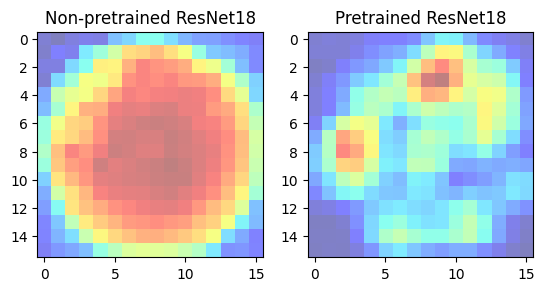

In [6]:
weight_params = list(model.fc.parameters())
weight_softmax = np.squeeze(weight_params[0].cpu().data.numpy())
class_idx = topk(probabilities, 1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

weight_params_wo = list(model_wo.fc.parameters())
weight_softmax_wo = np.squeeze(weight_params_wo[0].cpu().data.numpy())
class_idx_wo = topk(probabilities_wo, 1)[1].int()
overlay_wo = getCAM(activated_features_wo.features, weight_softmax_wo, class_idx_wo)

# weight_params_sp = list(model_sp.fc.parameters())
# weight_softmax_sp = np.squeeze(weight_params_sp[0].cpu().data.numpy())
# class_idx_sp = topk(probabilities_sp, 1)[1].int()
# overlay_sp = getCAM(activated_features_sp.features, weight_softmax_sp, class_idx_sp)

plt.subplot(1, 2, 1)
plt.title('Non-pretrained ResNet18')
plt.imshow(overlay_wo, alpha=0.5, cmap='jet')
# plt.subplot(1, 3, 2)
# plt.title('Simple pretrained ResNet18')
# plt.imshow(overlay_sp, alpha=0.5, cmap='jet')
plt.subplot(1, 2, 2)
plt.title('Pretrained ResNet18')
plt.imshow(overlay, alpha=0.5, cmap='jet')
plt.plot()

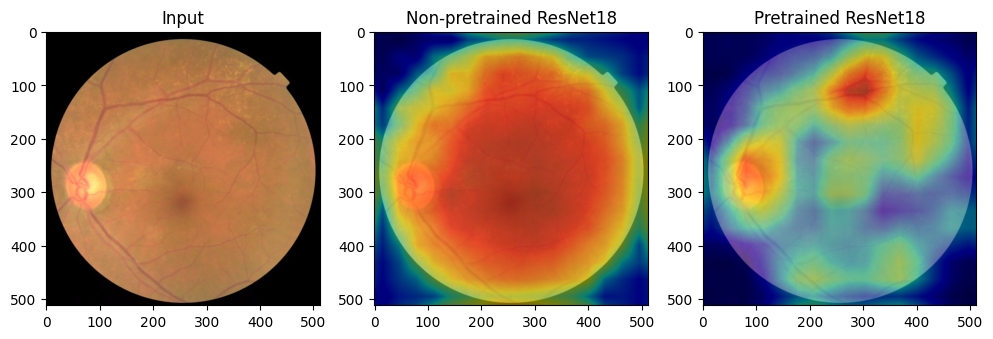

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title('Input')
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.title('Non-pretrained ResNet18')
plt.imshow(display_transform(image))
plt.imshow(skimage.transform.resize(overlay_wo, image_tensor.shape[1:3]), alpha=0.5, cmap='jet')
# plt.subplot(1, 4, 3)
# plt.title('Simple pretrained ResNet18')
# plt.imshow(display_transform(image))
# plt.imshow(skimage.transform.resize(overlay_sp, image_tensor.shape[1:3]), alpha=0.5, cmap='jet')
plt.subplot(1, 3, 3)
plt.title('Pretrained ResNet18')
plt.imshow(display_transform(image))
plt.imshow(skimage.transform.resize(overlay, image_tensor.shape[1:3]), alpha=0.5, cmap='jet')
plt.savefig('./figures/cam.png')